In [1]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
train = pd.read_csv('train_modified.csv')
target = 'Disbursed'
IDcol = 'ID'

In [6]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV Score : Mean - 0.8318589 | Std - 0.008756969 | Min - 0.820805 | Max - 0.8438558


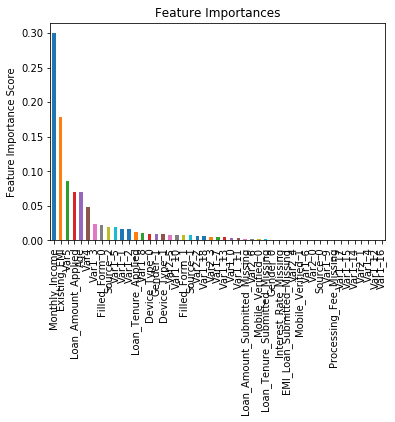

In [7]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

In [23]:
#Tune n_estimators 
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':[20,40,60,80]}
estimator=GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,
           max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)
gsearch1 = GridSearchCV(estimator = estimator, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 40, 60, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [25]:
#Tune max_depth and min_samplaes_split 
#param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
param_test2 = {'max_depth':[5,7,9,11,13,15,17], 'min_samples_split':[200,400,600,800,1000]}
estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt',subsample=0.8, random_state=10)

gsearch2 = GridSearchCV(estimator = estimator, param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83297, std: 0.01226, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.83251, std: 0.01054, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.83386, std: 0.01415, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.83379, std: 0.01169, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.83339, std: 0.01266, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.83365, std: 0.00787, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.83663, std: 0.00991, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.83480, std: 0.00828, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.83786, std: 0.01067, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.83769, std: 0.01060, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.83577, std: 0.00998, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.83729, std: 0.00959, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [26]:
#Tune min_samples_slip and min_samples_leaf 
param_test3 = {'min_samples_split':[1000,1200,1400,1600,1800,2000], 'min_samples_leaf':[30,40,50,60,70]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83821, std: 0.01092, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.83876, std: 0.01262, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.83552, std: 0.01024, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.83683, std: 0.01429, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.83958, std: 0.01233, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.83852, std: 0.01097, params: {'min_samples_leaf': 30, 'min_samples_split': 2000},
  mean: 0.83839, std: 0.00896, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.83757, std: 0.01274, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.83757, std: 0.01074, params: {'min_samples_leaf': 40, 'min_samples_split': 1400},
  mean: 0.83779, std: 0.01199, params: {'min_samples_leaf': 40, 'min_samples_split': 1600},
  mean: 0.83764, std: 0.01366, params: {'min_samples_leaf': 40, 'min_samples_spl


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.896453
CV Score : Mean - 0.8397598 | Std - 0.009936017 | Min - 0.8255474 | Max - 0.8527672


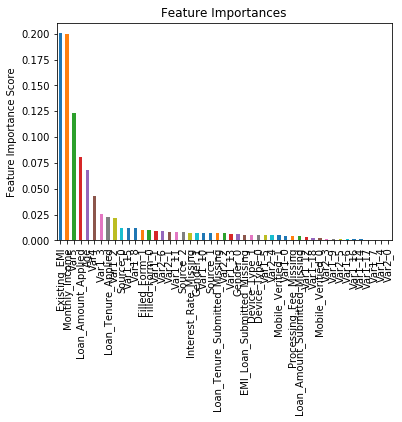

In [27]:
modelfit(gsearch3.best_estimator_, train, predictors)

In [28]:
#Tune max_features 
param_test4 = {'max_features':[7,9,11,13,15,17,19]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83976, std: 0.00994, params: {'max_features': 7},
  mean: 0.83648, std: 0.00988, params: {'max_features': 9},
  mean: 0.83919, std: 0.01042, params: {'max_features': 11},
  mean: 0.83738, std: 0.01017, params: {'max_features': 13},
  mean: 0.83898, std: 0.01101, params: {'max_features': 15},
  mean: 0.83437, std: 0.00965, params: {'max_features': 17},
  mean: 0.83524, std: 0.01018, params: {'max_features': 19}],
 {'max_features': 7},
 0.839759762884295)

In [29]:
#Tune subsamples 
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.83669, std: 0.00930, params: {'subsample': 0.6},
  mean: 0.83669, std: 0.01248, params: {'subsample': 0.7},
  mean: 0.83601, std: 0.01074, params: {'subsample': 0.75},
  mean: 0.83976, std: 0.00994, params: {'subsample': 0.8},
  mean: 0.84086, std: 0.00997, params: {'subsample': 0.85},
  mean: 0.83828, std: 0.00984, params: {'subsample': 0.9}],
 {'subsample': 0.85},
 0.840858008321874)

Tune n_estimators and learning lreate 


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.899962
CV Score : Mean - 0.8408708 | Std - 0.009994887 | Min - 0.8259353 | Max - 0.8522251


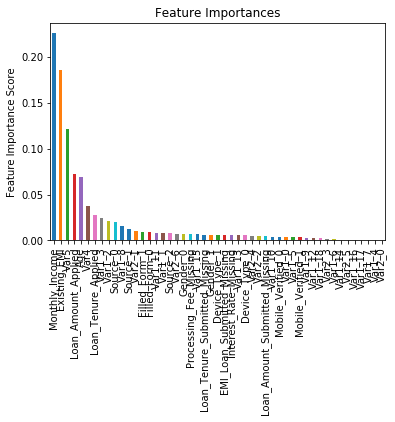

In [30]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=9, min_samples_split=1200,min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7)
modelfit(gbm_tuned_2, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.900744


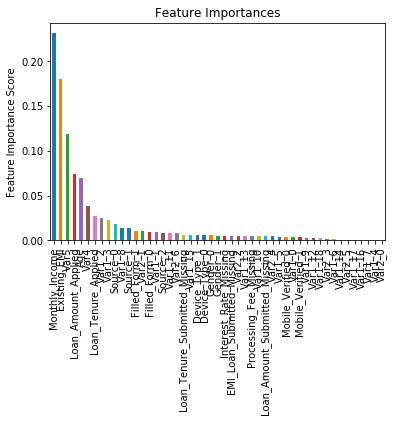

In [31]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7,
warm_start=True)
modelfit(gbm_tuned_3, train, predictors, performCV=False)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.906375


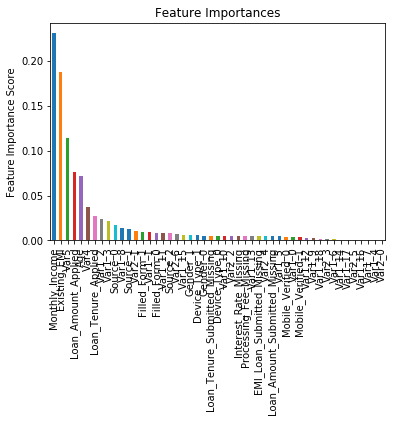

In [32]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7,
warm_start=True)
modelfit(gbm_tuned_4, train, predictors, performCV=False)